:
# Multiclass Segmentation — 5x5 Confusion Matrix Using Existing Data

This notebook trains a **multiclass** semantic segmentation model on your **existing tiles on Google Drive** and evaluates with a **5x5 confusion matrix** over foreground classes.

**Key features**
- Softmax head (multiclass), argmax predictions (no thresholds)
- Ignores `255` labels for loss/metrics
- Class imbalance handled with **masked, weighted categorical cross-entropy**
- Auto-selects the **top-5 foreground classes** by frequency (excluding background) for the 5x5 matrix — or set them manually


In [ ]:

# If running on Google Colab, uncomment the next line:
!pip -q install rasterio tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 68.9 MB/s eta 0:00:00


In [ ]:

from __future__ import annotations

import os, glob
from pathlib import Path
from typing import Tuple, List, Optional, Dict

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers as L, models as M
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import rasterio
from tqdm import tqdm

# ----------------------------
# Base configuration
# ----------------------------
# Tile/window
WIN    = 64
STRIDE = 32
SEED   = 42

# Classes
NUM_CLASSES = 6         # change if your labels use a different count
BACKGROUND_CLASS = 0
IGNORE_LABEL = 255

# 5x5 selection
# If None, we'll auto-select the 5 most frequent non-background classes from the training set.
EVAL_CLASSES = None
AUTO_SELECT_EVAL_CLASSES = True

# Model / training
MODEL_CHOICE = "deeplabv3plus_lite"  # {"unet", "resunet", "deeplabv3plus_lite"}
EPOCHS       = 50
BATCH_SIZE   = 64
LEARNING_RATE= 1e-3
SEED         = 1337

np.random.seed(SEED)
tf.random.set_seed(SEED)

print("TensorFlow:", tf.__version__)


TensorFlow: 2.19.0


In [ ]:

# ===== Mount Google Drive =====
import os
from google.colab import drive

MOUNT = '/content/gdrive'
os.makedirs(MOUNT, exist_ok=True)
drive.mount(MOUNT, force_remount=True)
print("Drive mounted?", os.path.exists(MOUNT))

# ===== Project roots =====
ROOT = "/content/gdrive/MyDrive/AA_GEOG_proj_training"
DATASETS = [
    "patches_less_polygons",
    "patches_more_polygons",
]
OUT_DIR = f"{ROOT}/outputs_models"
os.makedirs(OUT_DIR, exist_ok=True)

print("ROOT:", ROOT)
print("Datasets:", DATASETS)


Mounted at /content/gdrive
Drive mounted? True
ROOT: /content/gdrive/MyDrive/AA_GEOG_proj_training
Datasets: ['patches_less_polygons', 'patches_more_polygons']


In [ ]:

IMG_EXTS = (".tif", ".tiff")

def read_img(fp):
    with rasterio.open(fp) as src:
        arr = src.read().astype(np.float32)    # (C,H,W)
        nd = src.nodata
    if nd is not None:
        arr = np.where(arr == nd, np.nan, arr)
    return np.moveaxis(arr, 0, -1)            # -> (H,W,C)

def read_lbl(fp):
    with rasterio.open(fp) as src:
        lbl = src.read(1).astype(np.int32)    # (H,W)
        nd = src.nodata
    if nd is not None:
        lbl = np.where(lbl == nd, IGNORE_LABEL, lbl)
    return lbl

def pairs_from_map(map_txt, dataset_root):
    pairs = []
    with open(map_txt, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            img_rel, lbl_rel = line.split()
            img_fp = os.path.join(dataset_root, img_rel.replace("\\","/"))
            lbl_fp = os.path.join(dataset_root, lbl_rel.replace("\\","/"))
            pairs.append((img_fp, lbl_fp))
    return pairs

def pairs_by_basenames(img_dir, lbl_dir):
    imgs = {Path(p).stem: p for p in glob.glob(str(Path(img_dir) / "*")) if Path(p).suffix.lower() in IMG_EXTS}
    lbls = {Path(p).stem: p for p in glob.glob(str(Path(lbl_dir) / "*")) if Path(p).suffix.lower() in IMG_EXTS}
    common = sorted(set(imgs) & set(lbls))
    return [(imgs[s], lbls[s]) for s in common]

def load_arrays() -> Tuple[np.ndarray, np.ndarray]:
    all_pairs = []
    for ds in DATASETS:
        ds_root = f"{ROOT}/{ds}"
        img_dir = f"{ds_root}/images"
        lbl_dir = f"{ds_root}/labels"
        map_txt = f"{ds_root}/map.txt"
        if os.path.exists(map_txt):
            pairs = pairs_from_map(map_txt, ds_root)
        else:
            pairs = pairs_by_basenames(img_dir, lbl_dir)
        print(f"{ds}: {len(pairs)} pairs")
        all_pairs.extend(pairs)

    assert all_pairs, "No image/label pairs found. Check ROOT and folder structure."

    X_list, Y_list = [], []
    for img_fp, lbl_fp in tqdm(all_pairs, desc="Loading chips"):
        x = read_img(img_fp)
        y = read_lbl(lbl_fp)
        if x.shape[:2] != (WIN, WIN) or y.shape[:2] != (WIN, WIN):
            raise ValueError(f"Tile size mismatch: {img_fp} {x.shape[:2]} / {lbl_fp} {y.shape[:2]} expected {(WIN,WIN)}")
        X_list.append(np.nan_to_num(x, nan=0.0, posinf=1.0, neginf=0.0))
        Y_list.append(y)

    X = np.stack(X_list, axis=0)   # (N,WIN,WIN,C)
    Y = np.stack(Y_list, axis=0)   # (N,WIN,WIN)
    print("X:", X.shape, "Y:", Y.shape, "unique Y:", np.unique(Y))
    return X.astype('float32'), Y.astype('int32')


In [ ]:

def one_hot_with_mask(y_raw: np.ndarray, num_classes: int, ignore_label: int):
    valid = (y_raw != ignore_label).astype(np.float32)
    y_clip = np.where(valid > 0.5, y_raw, BACKGROUND_CLASS)  # send ignored to background bin to keep shape
    y_flat = y_clip.reshape(-1)
    onehot = np.eye(num_classes, dtype=np.float32)[y_flat]
    y_onehot = onehot.reshape(y_raw.shape + (num_classes,))
    valid_mask = valid[..., None]
    return y_onehot, valid_mask

def stack_y_and_mask(y_onehot: np.ndarray, valid_mask: np.ndarray) -> np.ndarray:
    return np.concatenate([y_onehot, valid_mask], axis=-1)

def infer_class_weights(y_raw_train: np.ndarray, num_classes: int, ignore_label: int) -> np.ndarray:
    counts = np.zeros((num_classes,), dtype=np.float64)
    valid = (y_raw_train != ignore_label)
    vals, freqs = np.unique(y_raw_train[valid], return_counts=True)
    counts[vals] = freqs
    counts = np.maximum(counts, 1)
    inv = 1.0 / counts
    weights = inv / inv.sum() * num_classes  # roughly unit-mean
    return weights.astype(np.float32)


In [ ]:

def conv_bn_relu(x, f, k=3, s=1):
    x = L.Conv2D(f, k, strides=s, padding='same', use_bias=False)(x)
    x = L.BatchNormalization()(x)
    x = L.Activation('relu')(x)
    return x

def unet(input_shape, num_classes):
    inputs = L.Input(shape=input_shape)
    c1 = conv_bn_relu(inputs, 32); c1 = conv_bn_relu(c1, 32); p1 = L.MaxPool2D()(c1)
    c2 = conv_bn_relu(p1, 64);     c2 = conv_bn_relu(c2, 64); p2 = L.MaxPool2D()(c2)
    c3 = conv_bn_relu(p2, 128);    c3 = conv_bn_relu(c3, 128); p3 = L.MaxPool2D()(c3)
    c4 = conv_bn_relu(p3, 256);    c4 = conv_bn_relu(c4, 256); p4 = L.MaxPool2D()(c4)
    bn = conv_bn_relu(p4, 512);    bn = conv_bn_relu(bn, 512)
    u4 = L.UpSampling2D()(bn);     u4 = L.Concatenate()([u4, c4]); u4 = conv_bn_relu(u4, 256); u4 = conv_bn_relu(u4, 256)
    u3 = L.UpSampling2D()(u4);     u3 = L.Concatenate()([u3, c3]); u3 = conv_bn_relu(u3, 128); u3 = conv_bn_relu(u3, 128)
    u2 = L.UpSampling2D()(u3);     u2 = L.Concatenate()([u2, c2]); u2 = conv_bn_relu(u2, 64);  u2 = conv_bn_relu(u2, 64)
    u1 = L.UpSampling2D()(u2);     u1 = L.Concatenate()([u1, c1]); u1 = conv_bn_relu(u1, 32);  u1 = conv_bn_relu(u1, 32)
    logits = L.Conv2D(num_classes, 1, padding='same')(u1)
    outputs = L.Softmax(axis=-1)(logits)
    return M.Model(inputs, outputs, name='UNet')

def res_block(x, f):
    shortcut = x
    x = conv_bn_relu(x, f)
    x = L.Conv2D(f, 3, padding='same', use_bias=False)(x)
    x = L.BatchNormalization()(x)
    if shortcut.shape[-1] != f:
        shortcut = L.Conv2D(f, 1, padding='same', use_bias=False)(shortcut)
        shortcut = L.BatchNormalization()(shortcut)
    x = L.Add()([x, shortcut])
    x = L.Activation('relu')(x)
    return x

def resunet(input_shape, num_classes):
    inputs = L.Input(shape=input_shape)
    c1 = conv_bn_relu(inputs, 32); c1 = res_block(c1, 32); p1 = L.MaxPool2D()(c1)
    c2 = conv_bn_relu(p1, 64);     c2 = res_block(c2, 64);  p2 = L.MaxPool2D()(c2)
    c3 = conv_bn_relu(p2, 128);    c3 = res_block(c3, 128); p3 = L.MaxPool2D()(c3)
    c4 = conv_bn_relu(p3, 256);    c4 = res_block(c4, 256); p4 = L.MaxPool2D()(c4)
    bn = conv_bn_relu(p4, 512);    bn = res_block(bn, 512)
    u4 = L.UpSampling2D()(bn);     u4 = L.Concatenate()([u4, c4]); u4 = res_block(u4, 256)
    u3 = L.UpSampling2D()(u4);     u3 = L.Concatenate()([u3, c3]); u3 = res_block(u3, 128)
    u2 = L.UpSampling2D()(u3);     u2 = L.Concatenate()([u2, c2]); u2 = res_block(u2, 64)
    u1 = L.UpSampling2D()(u2);     u1 = L.Concatenate()([u1, c1]); u1 = res_block(u1, 32)
    logits = L.Conv2D(num_classes, 1, padding='same')(u1)
    outputs = L.Softmax(axis=-1)(logits)
    return M.Model(inputs, outputs, name='ResUNet')

def atrous_spatial_pyramid_pooling(x, out_channels=128):
    dims = x.shape
    y1 = L.Conv2D(out_channels, 1, padding='same', activation='relu')(x)
    y2 = L.Conv2D(out_channels, 3, dilation_rate=6, padding='same', activation='relu')(x)
    y3 = L.Conv2D(out_channels, 3, dilation_rate=12, padding='same', activation='relu')(x)
    y4 = L.Conv2D(out_channels, 3, dilation_rate=18, padding='same', activation='relu')(x)
    y5 = L.AveragePooling2D(pool_size=(dims[1], dims[2]))(x)
    y5 = L.Conv2D(out_channels, 1, padding='same', activation='relu')(y5)
    y5 = L.UpSampling2D(size=(dims[1], dims[2]), interpolation='bilinear')(y5)
    y = L.Concatenate()([y1, y2, y3, y4, y5])
    y = L.Conv2D(out_channels, 1, padding='same', activation='relu')(y)
    return y

def deeplabv3plus_lite(input_shape, num_classes):
    inputs = L.Input(shape=input_shape)
    x = conv_bn_relu(inputs, 32, 3, 2)  # 32x32
    x = conv_bn_relu(x, 64, 3, 2)       # 16x16
    x = conv_bn_relu(x, 128, 3, 2)      # 8x8
    aspp = atrous_spatial_pyramid_pooling(x, 128)
    x = L.UpSampling2D(size=(8, 8), interpolation='bilinear')(aspp)  # back to 64x64
    x = conv_bn_relu(x, 128)
    logits = L.Conv2D(num_classes, 1, padding='same')(x)
    outputs = L.Softmax(axis=-1)(logits)
    return M.Model(inputs, outputs, name='DeepLabV3plusLite')


In [ ]:

class MaskedWeightedCCE(tf.keras.losses.Loss):
    def __init__(self, class_weights: Optional[np.ndarray] = None, name='masked_weighted_cce'):
        super().__init__(name=name)
        self.class_weights = None if class_weights is None else tf.constant(class_weights, dtype=tf.float32)
        self.ce = CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)

    def call(self, y_true_ext, y_pred):
        y_true, valid = tf.split(y_true_ext, [NUM_CLASSES, 1], axis=-1)
        per_pixel_ce = self.ce(y_true, y_pred)  # (N,H,W)
        if self.class_weights is not None:
            weights = tf.tensordot(y_true, self.class_weights, axes=[-1, 0])  # (N,H,W)
            per_pixel_ce = per_pixel_ce * weights
        per_pixel_ce = per_pixel_ce * tf.squeeze(valid, axis=-1)
        denom = tf.reduce_sum(valid) + 1e-8
        return tf.reduce_sum(per_pixel_ce) / denom

def compute_confusion_kxk(y_true_raw: np.ndarray,
                          y_pred_raw: np.ndarray,
                          classes: List[int],
                          ignore_label: int = IGNORE_LABEL,
                          drop_preds_outside: bool = True) -> Tuple[np.ndarray, int]:
    """
    Build a K×K confusion matrix over 'classes' (length K), ignoring:
      - y_true == ignore_label
      - y_true not in 'classes'
    Predictions not in 'classes' are mapped to -1 and, by default, DROPPED so
    the matrix stays K×K. Returns (cm, num_dropped_preds).
    """
    classes = [int(c) for c in classes]
    k = len(classes)
    assert k >= 2, "Need at least two classes for a confusion matrix."
    class_to_idx = {int(c): i for i, c in enumerate(classes)}

    # Keep only valid gt pixels
    mask_valid = (y_true_raw != ignore_label)
    y_true = y_true_raw[mask_valid].reshape(-1)
    y_pred = y_pred_raw[mask_valid].reshape(-1)

    # Keep only rows where TRUE label is one of the selected classes
    keep_true = np.isin(y_true, classes)
    y_true = y_true[keep_true]
    y_pred = y_pred[keep_true]

    # Remap true labels to [0..k-1]
    y_true_m = np.vectorize(lambda z: class_to_idx[int(z)], otypes=[int])(y_true)

    # Remap predictions; anything outside 'classes' -> -1 sentinel
    y_pred_m = np.vectorize(lambda z: class_to_idx.get(int(z), -1), otypes=[int])(y_pred)
    dropped = int(np.sum(y_pred_m == -1))

    if drop_preds_outside and dropped > 0:
        keep = (y_pred_m != -1)
        y_true_m = y_true_m[keep]
        y_pred_m = y_pred_m[keep]

    cm = confusion_matrix(y_true_m, y_pred_m, labels=list(range(k)))
    return cm.astype(np.int64), dropped


def metrics_from_cm(cm: np.ndarray) -> dict:
    tp = np.diag(cm).astype(np.float64)
    fp = cm.sum(axis=0) - tp
    fn = cm.sum(axis=1) - tp

    precision = np.divide(tp, tp + fp, out=np.zeros_like(tp), where=(tp + fp) > 0)
    recall    = np.divide(tp, tp + fn, out=np.zeros_like(tp), where=(tp + fn) > 0)
    f1        = np.divide(2*precision*recall, precision + recall, out=np.zeros_like(tp), where=(precision + recall) > 0)
    iou       = np.divide(tp, tp + fp + fn, out=np.zeros_like(tp), where=(tp + fp + fn) > 0)

    return {
        'per_class': {
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'iou': iou,
        },
        'macro': {
            'precision': float(np.mean(precision)),
            'recall': float(np.mean(recall)),
            'f1': float(np.mean(f1)),
            'miou': float(np.mean(iou)),
        }
    }

def plot_confusion(cm: np.ndarray, classes: List[int], class_names: Dict[int,str], title: str = "5x5 Confusion Matrix"):
    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(cm, interpolation='nearest')
    ax.set_title(title)
    tick_labels = [class_names.get(c, f"{c}") for c in classes]
    ax.set_xticks(range(len(classes)))
    ax.set_yticks(range(len(classes)))
    ax.set_xticklabels(tick_labels, rotation=45, ha='right')
    ax.set_yticklabels(tick_labels)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, str(cm[i, j]), ha='center', va='center')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    fig.tight_layout()
    plt.show()


In [ ]:

# Load arrays from Drive
X, Y = load_arrays()

# Set derived shapes
num_channels = X.shape[-1]
INPUT_SHAPE = (WIN, WIN, num_channels)

print("Derived INPUT_SHAPE:", INPUT_SHAPE)

# Split
def train_val_test_split(N: int, val_frac: float = 0.08, test_frac: float = 0.09):
    idx = np.arange(N)
    np.random.shuffle(idx)
    n_val = int(round(N * val_frac))
    n_test = int(round(N * test_frac))
    val_idx = idx[:n_val]
    test_idx = idx[n_val:n_val + n_test]
    train_idx = idx[n_val + n_test:]
    return train_idx, val_idx, test_idx

train_idx, val_idx, test_idx = train_val_test_split(len(X))
X_tr, Y_tr = X[train_idx], Y[train_idx]
X_va, Y_va = X[val_idx], Y[val_idx]
X_te, Y_te = X[test_idx], Y[test_idx]

# One-hot + mask
ytr_oh, mtr = one_hot_with_mask(Y_tr, NUM_CLASSES, IGNORE_LABEL)
yva_oh, mva = one_hot_with_mask(Y_va, NUM_CLASSES, IGNORE_LABEL)
YTR_EXT = stack_y_and_mask(ytr_oh, mtr)
YVA_EXT = stack_y_and_mask(yva_oh, mva)

# Class weights
cw = infer_class_weights(Y_tr, NUM_CLASSES, IGNORE_LABEL)
print("Class weights:", np.round(cw, 4))

# Auto-select EVAL_CLASSES if requested
if EVAL_CLASSES is None and AUTO_SELECT_EVAL_CLASSES:
    valid = (Y_tr != IGNORE_LABEL) & (Y_tr != BACKGROUND_CLASS)
    vals, freqs = np.unique(Y_tr[valid], return_counts=True)
    # pick top-5 by frequency
    order = np.argsort(freqs)[::-1]
    top = vals[order][:5]
    if len(top) < 5:
        raise ValueError(f"Not enough foreground classes to form a 5x5 matrix; found {len(top)} foreground classes.")
    EVAL_CLASSES = list(map(int, top))
    print("Auto-selected EVAL_CLASSES:", EVAL_CLASSES)
else:
    assert EVAL_CLASSES is not None and len(EVAL_CLASSES) == 5, "EVAL_CLASSES must be a list of 5 class ids."

# Optional names
CLASS_NAMES = {i: f"class_{i}" for i in range(NUM_CLASSES)}
CLASS_NAMES[BACKGROUND_CLASS] = "background"

# Build model
if MODEL_CHOICE == "unet":
    model = unet(INPUT_SHAPE, NUM_CLASSES)
elif MODEL_CHOICE == "resunet":
    model = resunet(INPUT_SHAPE, NUM_CLASSES)
elif MODEL_CHOICE in ("deeplabv3plus_lite", "deeplab", "deeplabv3+"):
    model = deeplabv3plus_lite(INPUT_SHAPE, NUM_CLASSES)
else:
    raise ValueError("Unknown MODEL_CHOICE")

loss = MaskedWeightedCCE(class_weights=cw)
opt = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
model.summary()

ckpt = ModelCheckpoint(f"{OUT_DIR}/best_{MODEL_CHOICE}.keras", monitor='val_loss', save_best_only=True, verbose=1)
early = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
reduce = ReduceLROnPlateau(monitor='val_loss', patience=4, factor=0.5, verbose=1)

history = model.fit(
    X_tr, YTR_EXT,
    validation_data=(X_va, YVA_EXT),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[ckpt, early, reduce],
    verbose=1,
)

patches_less_polygons: 116 pairs
patches_more_polygons: 50 pairs


Loading chips: 100%|██████████| 166/166 [01:07<00:00,  2.45it/s]


X: (166, 64, 64, 12) Y: (166, 64, 64) unique Y: [0 1 2 3 4 5]
Derived INPUT_SHAPE: (64, 64, 12)
Class weights: [0.0129 3.0169 1.8864 0.373  0.1085 0.6022]
Auto-selected EVAL_CLASSES: [4, 3, 5, 2, 1]


Model: "DeepLabV3plusLite"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64,    │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │      3,456 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32,    │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 16, 16,    │     18,432 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 8, 8, 128) │     73,728 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 128) │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 8, 8, 128) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d   │ (None, 1, 1, 128) │          0 │ activation_2[0][… │
│ (AveragePooling2D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 1, 1, 128) │     16,512 │ average_pooling2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 8, 8, 128) │     16,512 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 8, 8, 128) │    147,584 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 8, 8, 128) │    147,584 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 8, 8, 128) │    147,584 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 8, 8, 128) │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 8, 8, 640) │          0 │ conv2d_3[0][0],   │
│ (Concatenate)       │                   │            │ conv2d_4[0][0],   │
│                     │                   │            │ conv2d_5[0][0],   │
│                     │                   │            │ conv2d_6[0][0], 

 Total params: 803,078 (3.06 MB)

 Trainable params: 802,374 (3.06 MB)

 Non-trainable params: 704 (2.75 KB)

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.1429 - loss: 0.1099
Epoch 1: val_loss improved from inf to 0.16037, saving model to /content/gdrive/MyDrive/AA_GEOG_proj_training/outputs_models/best_deeplabv3plus_lite.keras
3/3 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - accuracy: 0.1445 - loss: 0.1074 - val_accuracy: 0.8372 - val_loss: 0.1604 - learning_rate: 0.0010
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.1672 - loss: 0.0624
Epoch 2: val_loss improved from 0.16037 to 0.15986, saving model to /content/gdrive/MyDrive/AA_GEOG_proj_training/outputs_models/best_deeplabv3plus_lite.keras
3/3 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - accuracy: 0.1688 - loss: 0.0618 - val_accuracy: 0.7581 - val_loss: 0.1599 - learning_rate: 0.0010
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2261 - loss: 0.0506
Epoch 3: val_loss improved from 0.15986 to 0.15952, saving model to /content/gdrive/MyDrive/AA_GEOG_proj_training/outputs_models/best_deeplabv3plus_lite.keras
3/3 ━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
5x5 Confusion matrix (rows=true, cols=pred) over classes [4, 3, 5, 2, 1]
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
NOTE: 9891 predictions were outside EVAL_CLASSES and were excluded to keep the matrix 5x5.

Per-class metrics (order matches EVAL_CLASSES):
precision: [0. 0. 0. 0. 0.]
   recall: [0. 0. 0. 0. 0.]
       f1: [0. 0. 0. 0. 0.]
      iou: [0. 0. 0. 0. 0.]

Macro averages:
precision: 0.0000
   recall: 0.0000
       f1: 0.0000
     miou: 0.0000


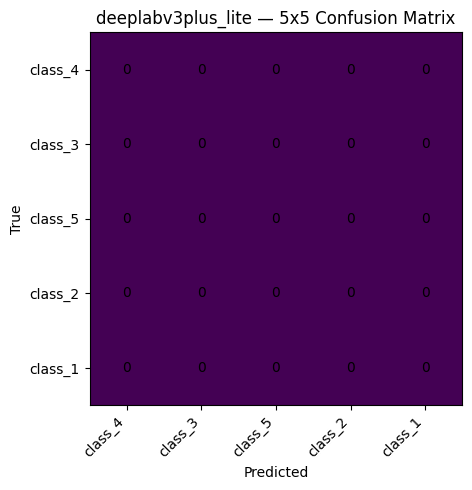

In [ ]:
# Predict & evaluate
Y_pred_proba = model.predict(X_te, batch_size=BATCH_SIZE)
Y_pred = np.argmax(Y_pred_proba, axis=-1).astype(np.int32)  # (N,H,W)

cm5, dropped = compute_confusion_kxk(Y_te, Y_pred, classes=EVAL_CLASSES, ignore_label=IGNORE_LABEL)
print("5x5 Confusion matrix (rows=true, cols=pred) over classes", EVAL_CLASSES)
print(cm5)
if dropped:
    print(f"NOTE: {dropped} predictions were outside EVAL_CLASSES and were excluded to keep the matrix 5x5.")

m = metrics_from_cm(cm5)
print("\nPer-class metrics (order matches EVAL_CLASSES):")
for k, arr in m['per_class'].items():
    print(f"{k:>9}:", np.round(arr, 4))

print("\nMacro averages:")
for k, v in m['macro'].items():
    print(f"{k:>9}: {v:.4f}")

plot_confusion(cm5, classes=EVAL_CLASSES, class_names=CLASS_NAMES, title=f"{MODEL_CHOICE} — 5x5 Confusion Matrix")
